In [39]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

In [3]:
fpath = 'facebook_data_CNN_post_sentiment.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,Text,Likes,Shares,PositiveScore,NegativeScore,NeutralScore,SentimentScore,TokenQnt,PositiveScoreAvg,NegativeScoreAvg,NeutralScoreAvg,SentimentScoreAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound,Flair_Score
0,1,10162001067901509,2021-05-16 18:33:17,"""If we can't as an international community pre...",159,0,2.375,3.250,16.375,-0.875,22,0.107955,0.147727,0.744318,-0.039773,0.112,0.073,0.815,0.2960,-0.9944
1,2,10162000992086509,2021-05-16 18:01:11,In a sign of the Biden administration's embrac...,389,20,0.875,0.000,18.125,0.875,19,0.046053,0.000000,0.953947,0.046053,0.117,0.060,0.823,0.6249,-0.6481
2,3,10162000989931509,2021-05-16 18:00:31,What’s your favorite David Letterman bit? Hear...,59,0,0.625,0.500,13.875,0.125,15,0.041667,0.033333,0.925000,0.008333,0.142,0.000,0.858,0.5859,-0.6877
3,4,10162000949151509,2021-05-16 17:41:09,"""The Republican Party's decision, in effect, t...",315,0,1.000,0.500,10.500,0.500,12,0.083333,0.041667,0.875000,0.041667,0.062,0.000,0.938,0.4019,0.9245
4,5,10162000877181509,2021-05-16 17:00:52,"A group of more than 150 Republicans, led by D...",534,176,1.000,0.375,20.625,0.625,22,0.045455,0.017045,0.937500,0.028409,0.049,0.065,0.886,0.0258,0.5893


In [4]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

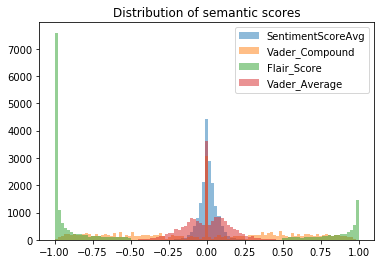

In [5]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['SentimentScoreAvg'], bins, alpha=0.5, label='SentimentScoreAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Flair_Score'], bins, alpha=0.5, label='Flair_Score')
pyplot.hist(post_data['Vader_Average'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

Text(0, 0.5, 'Posts')

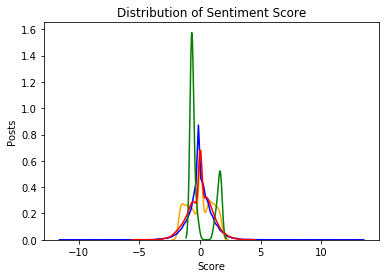

In [6]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['SentimentScoreAvg'] - post_data['SentimentScoreAvg'].mean())/post_data['SentimentScoreAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Flair_Score'] - post_data['Flair_Score'].mean())/post_data['Flair_Score'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [7]:
post_data[['SentimentScoreAvg','Vader_Compound','Flair_Score','Vader_Average']].describe()

,SentimentScoreAvg,Vader_Compound,Flair_Score,Vader_Average
count,18092.000000,18092.000000,18092.000000,18092.000000
mean,0.009066,-0.012064,-0.416013,-0.001990
std,0.056288,0.536233,0.820549,0.143122
min,-0.625000,-0.989800,-1.000000,-0.750000
25%,-0.017094,-0.476700,-0.997100,-0.091000
50%,0.000000,0.000000,-0.948550,0.000000
75%,0.037500,0.421500,0.647425,0.087000
max,0.750000,0.989200,1.000000,0.590000


In [8]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [9]:
post_data['DateMonth'].head()

0    2021-05
1    2021-05
2    2021-05
3    2021-05
4    2021-05
Name: DateMonth, dtype: object

In [10]:
Monthly_Data = post_data.groupby('DateMonth').agg({'SentimentScore': 'sum'
                                                         ,'TokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'Flair_Score':'mean'})

In [11]:
DailyData = post_data.groupby('DateDay').agg({'SentimentScore': 'sum'
                                                         ,'TokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'Flair_Score':'mean'})

In [12]:
DailyData['SentimentScoreAdj'] = DailyData['SentimentScore']/DailyData['TokenQnt']
Monthly_Data['SentimentScoreAdj'] = Monthly_Data['SentimentScore']/Monthly_Data['TokenQnt']


In [13]:
DailyData.head()

,SentimentScore,TokenQnt,Vader_Compound,Vader_Average,Flair_Score,SentimentScoreAdj
DateDay,,,,,,
2010-08-23,2.625,2,0.550800,0.165500,-0.985250,1.312500
2010-08-24,1.125,3,0.128733,0.014667,0.307800,0.375000
2010-08-25,-0.500,3,-0.359700,-0.085333,-0.472200,-0.166667
2010-08-26,0.375,3,-0.142767,-0.071333,-0.981700,0.125000
2010-08-27,1.125,3,-0.205667,-0.029333,-0.397533,0.375000


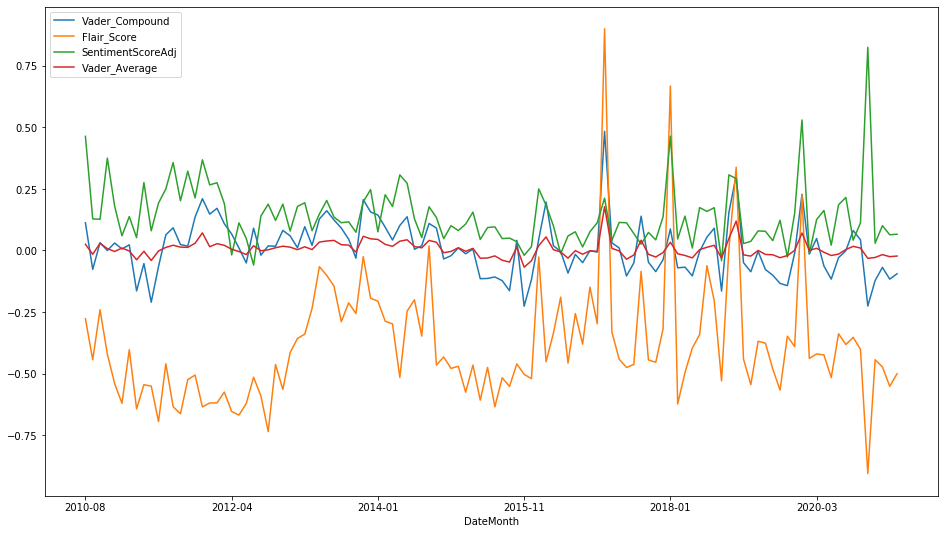

In [14]:
Monthly_Data[['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']].plot(legend=True, figsize=(16,9))

In [43]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['Vader_Average'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -7.814732e+00
p-value                        6.918550e-12
#Lags Used                     2.100000e+01
Number of Observations Used    2.428000e+03
Critical Value (1%)           -3.433046e+00
Critical Value (5%)           -2.862731e+00
Critical Value (10%)          -2.567404e+00
dtype: float64


## Download S&P from Yahoo

In [15]:
SnP_daily = web.get_data_yahoo('^GSPC','01/01/2010','05/01/2021',interval='d')
SnP_monthly = web.get_data_yahoo('^GSPC','01/01/2010','05/01/2021',interval='m')

In [16]:
SnP_monthly

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-09-01,1157.160034,1049.719971,1049.719971,1141.199951,79589450000,1141.199951
2010-10-01,1196.140015,1131.869995,1143.489990,1183.260010,89536270000,1183.260010
2010-11-01,1227.079956,1173.000000,1185.709961,1180.550049,87151070000,1180.550049
2010-12-01,1262.599976,1186.599976,1186.599976,1257.640015,80984530000,1257.640015
2011-01-01,1302.670044,1257.619995,1257.619995,1286.119995,92164940000,1286.119995
...,...,...,...,...,...,...
2020-11-01,3645.989990,3279.739990,3296.199951,3621.629883,100977880000,3621.629883
2020-12-01,3760.199951,3633.399902,3645.870117,3756.070068,96056410000,3756.070068
2021-01-01,3870.899902,3662.709961,3764.610107,3714.239990,105548790000,3714.239990


In [17]:
SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [18]:
SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

In [19]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [20]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [21]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [22]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [23]:
Granger_data_monthly

,High,Low,Open,Close,Volume,Adj Close,LogReturn,SentimentScore,TokenQnt,Vader_Compound,Vader_Average,Flair_Score,SentimentScoreAdj
2010-09,1157.160034,1049.719971,1049.719971,1141.199951,79589450000,1141.199951,NaN,7.819000,61,-0.076744,-0.015410,-0.443802,0.128180
2010-10,1196.140015,1131.869995,1143.489990,1183.260010,89536270000,1183.260010,0.036193,9.125000,72,0.031511,0.029139,-0.240363,0.126736
2010-11,1227.079956,1173.000000,1185.709961,1180.550049,87151070000,1180.550049,-0.002293,24.750000,66,-0.000118,0.007515,-0.421012,0.375000
2010-12,1262.599976,1186.599976,1186.599976,1257.640015,80984530000,1257.640015,0.063256,9.875000,55,0.030304,-0.004000,-0.540476,0.179545
2011-01,1302.670044,1257.619995,1257.619995,1286.119995,92164940000,1286.119995,0.022393,3.875000,65,0.006220,0.009785,-0.620715,0.059615
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11,3645.989990,3279.739990,3296.199951,3621.629883,100977880000,3621.629883,0.102146,2.625000,63,0.080956,0.016730,-0.352633,0.041667
2020-12,3760.199951,3633.399902,3645.870117,3756.070068,96056410000,3756.070068,0.036449,39.375000,349,0.043433,0.009891,-0.401473,0.112822
2021-01,3870.899902,3662.709961,3764.610107,3714.239990,105548790000,3714.239990,-0.011199,4.125000,5,-0.225740,-0.032000,-0.905860,0.825000
2021-02,3950.429932,3725.620117,3731.169922,3811.149902,98596960000,3811.149902,0.025757,7.121968,243,-0.122481,-0.028366,-0.443611,0.029309


In [36]:
gc_res = grangercausalitytests(Granger_data_daily[["Vader_Compound","LogReturn"]].dropna(),11)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8622  , p=0.1726  , df_denom=1679, df_num=1
ssr based chi2 test:   chi2=1.8655  , p=0.1720  , df=1
likelihood ratio test: chi2=1.8645  , p=0.1721  , df=1
parameter F test:         F=1.8622  , p=0.1726  , df_denom=1679, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6131  , p=0.1996  , df_denom=1676, df_num=2
ssr based chi2 test:   chi2=3.2359  , p=0.1983  , df=2
likelihood ratio test: chi2=3.2328  , p=0.1986  , df=2
parameter F test:         F=1.6131  , p=0.1996  , df_denom=1676, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3029  , p=0.2719  , df_denom=1673, df_num=3
ssr based chi2 test:   chi2=3.9252  , p=0.2697  , df=3
likelihood ratio test: chi2=3.9206  , p=0.2702  , df=3
parameter F test:         F=1.3029  , p=0.2719  , df_denom=1673, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2994  , p=0.

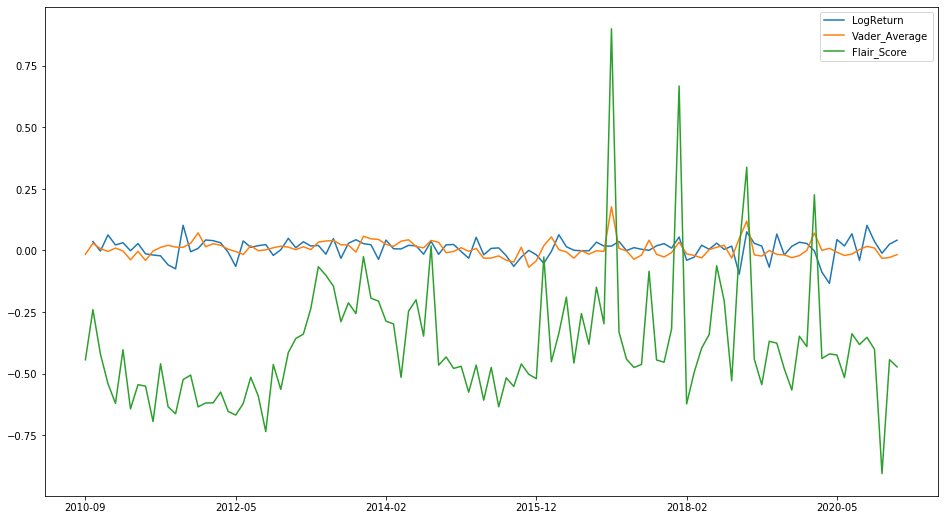

In [37]:
Granger_data_monthly[['LogReturn','Vader_Average','Flair_Score']].plot(legend=True, figsize=(16,9))

In [28]:
corr = Granger_data_daily[['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average', 'LogReturn']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Flair_Score,SentimentScoreAdj,Vader_Average,LogReturn
Vader_Compound,1.000000,0.320595,0.379994,0.924630,-0.021000
Flair_Score,0.320595,1.000000,0.090680,0.349603,0.013418
SentimentScoreAdj,0.379994,0.090680,1.000000,0.356722,-0.016887
Vader_Average,0.924630,0.349603,0.356722,1.000000,-0.013421
LogReturn,-0.021000,0.013418,-0.016887,-0.013421,1.000000


In [29]:
pvals = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif

,p-value
Vader_Compound,0.389257
Flair_Score,0.582255
SentimentScoreAdj,0.488753
Vader_Average,0.582188


In [30]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.385059
Flair_Score,0.075394
SentimentScoreAdj,0.809756
Vader_Average,0.376956
